# Explore MEL data with Spark
The purpose of this notebook is to validate the labelling of the mel spectrogram observations. Apache Spark is used as it is more performant when working with large files.

### Initialise Spark

In [4]:
import findspark
findspark.init('/Volumes/Thorshammer/Applications/spark')

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Jupyter").getOrCreate()

spark.version

u'2.1.0'

In [98]:
sample_rate = 16000
sample_length = 4
stride = 0.01
# This following represent the first postive class observation in the data
positive_classes = {
    '161225-001' : 9541250,
    '161225-002' : 713600,
    '161225-003' : 813800,
    '161225-004' : 808700,
    '161225-005' : 686400
}

file_sufix = '.wav-mel.csv'
mel_directory = r'/Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/'

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import librosa
import librosa.display
import os

def calc_mel_observation_index(raw_sample_number):
    observation_index = int(raw_sample_number / (sample_rate * stride))
    return observation_index

def plot_mel(data, hop_length):
    librosa.display.specshow(data, x_axis='time', sr=sample_rate, y_axis='mel', hop_length=hop_length)

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()
    plt.show()

import numpy as np
# for key in positive_classes:
def load_mel_data_rdd(filename):
    '''
    Load mel data from disk. Data is an array of mel 2d matrices.
    We need to iterate the array and reshape each matrix.
    Each matrix has dimensions 40 x 401 (there are 40 mel channels for a 4 sec sample).
    '''
    print('Loading mel data: %s'%filename)

    raw_lines_rdd = spark \
        .sparkContext \
        .textFile(filename) \
        .map(lambda line: line.split(',')) \
        .map(lambda v: map(float,v)) \
        .map(lambda v: np.asarray(v).reshape((40,401))) \
        .zipWithIndex()

    return raw_lines_rdd

def get_mel_for_sample_index(rdd, sample_index) :
    return rdd.filter(lambda (x,y): y == calc_mel_observation_index(sample_index)).take(1)[0][0]

def get_mel_for_observation_index(rdd, observation_index) :
    return rdd.filter(lambda (x,y): y == observation_index).take(1)[0][0]

### Look at the mel spectrograph observations

In [129]:
key = positive_classes.keys()[2]

filename = os.path.join(mel_directory,key+file_sufix)

mel_data = load_mel_data_rdd(filename)

mel_observation = get_mel_for_sample_index(mel_data,positive_classes[key])

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-002.wav-mel.csv


In [130]:
mel_observation

array([[-32.53118126, -32.40407818, -32.06691815, ..., -31.37569038,
        -32.27294457, -32.65273438],
       [-37.106318  , -37.47061004, -38.51109746, ..., -36.10655722,
        -36.36921429, -36.47559548],
       [-38.31799643, -38.59748107, -39.40783399, ..., -37.2814235 ,
        -38.28922789, -38.74251936],
       ..., 
       [-46.36428266, -46.84007971, -48.25661109, ..., -60.82515073,
        -60.62413029, -60.55040145],
       [-46.73476755, -47.23390113, -48.75845015, ..., -61.4149162 ,
        -61.49066598, -61.52097104],
       [-47.30127119, -47.81350491, -49.40029154, ..., -63.56722004,
        -63.29179475, -63.19744731]])

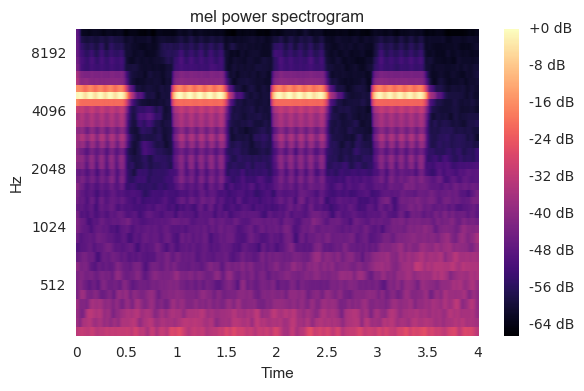

In [131]:
plot_mel(mel_observation,160)

### Look at the boundary plots of the mel observation for each target
The first set of plots show the target at one extream of the target class observation time window.

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-001.wav-mel.csv
Loaded. Processing mel at index: 59632


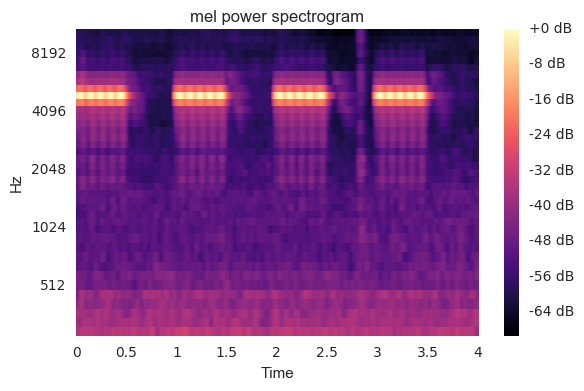

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-002.wav-mel.csv
Loaded. Processing mel at index: 4460


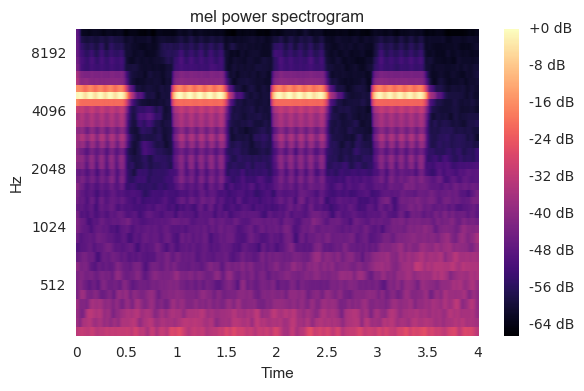

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-003.wav-mel.csv
Loaded. Processing mel at index: 5086


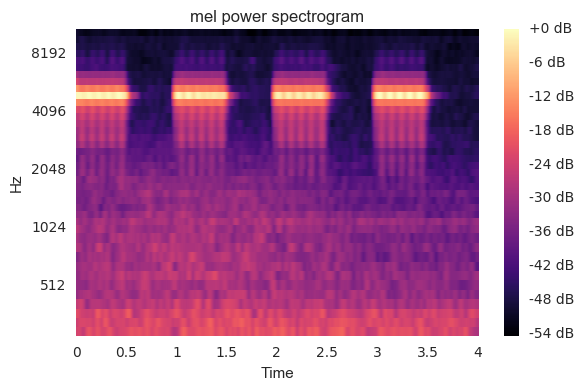

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-004.wav-mel.csv
Loaded. Processing mel at index: 5054


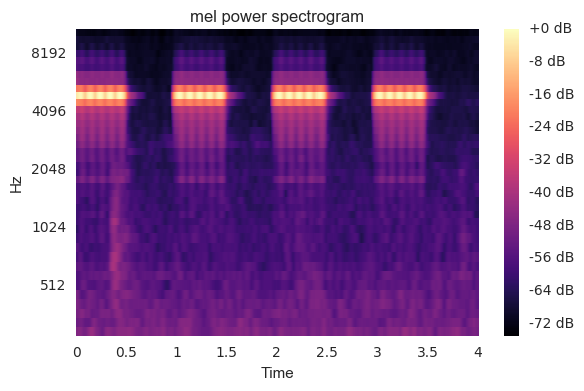

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-005.wav-mel.csv
Loaded. Processing mel at index: 4290


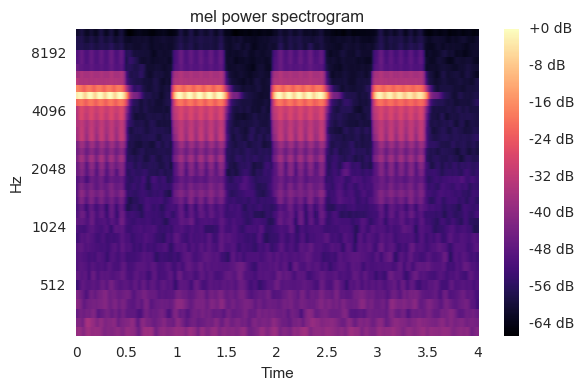

CPU times: user 4.13 s, sys: 864 ms, total: 4.99 s
Wall time: 8min 25s


In [134]:
%%time
# Loop through the audio files with a positive class and plot the sample observation

for key in sorted(positive_classes.keys()):
    filename = os.path.join(mel_directory,key+file_sufix)
    mel_data = load_mel_data_rdd(filename)
    mel_index = calc_mel_observation_index(positive_classes[key])
    print('Loaded. Processing mel at index: %i'%mel_index)
    mel_observation = get_mel_for_observation_index(mel_data,mel_index)
    plot_mel(mel_observation, int(sample_rate * stride))

This next set of plots show the target at the other extream of the observation time window.

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-001.wav-mel.csv
Loaded. Processing mel at index: 59582


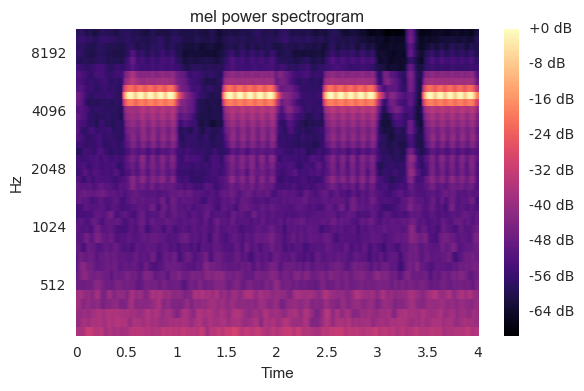

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-002.wav-mel.csv
Loaded. Processing mel at index: 4410


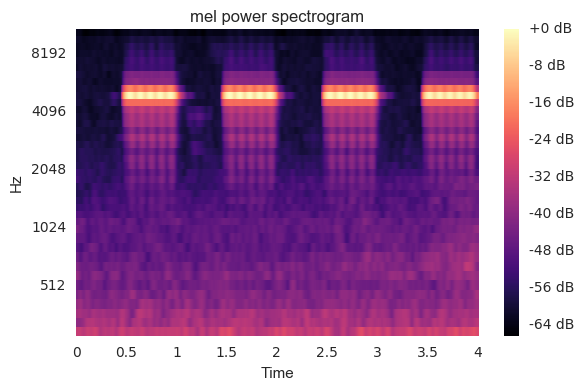

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-003.wav-mel.csv
Loaded. Processing mel at index: 5036


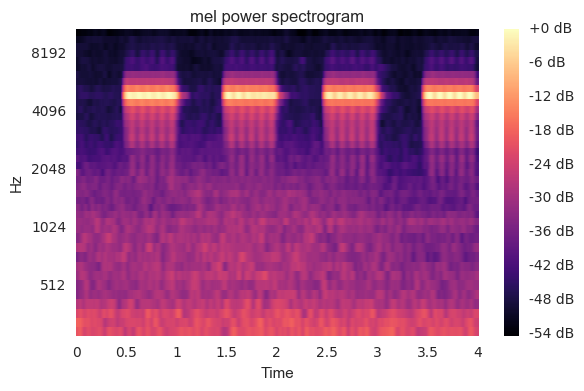

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-004.wav-mel.csv
Loaded. Processing mel at index: 5004


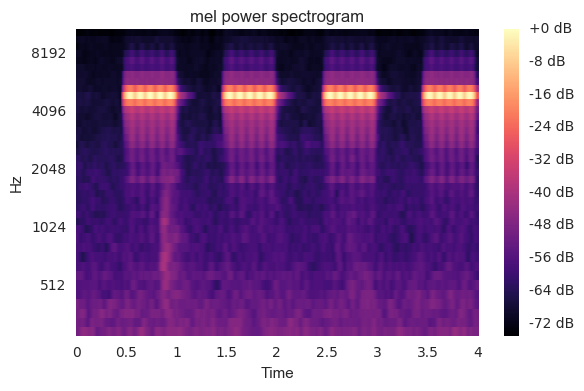

Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-005.wav-mel.csv
Loaded. Processing mel at index: 4240


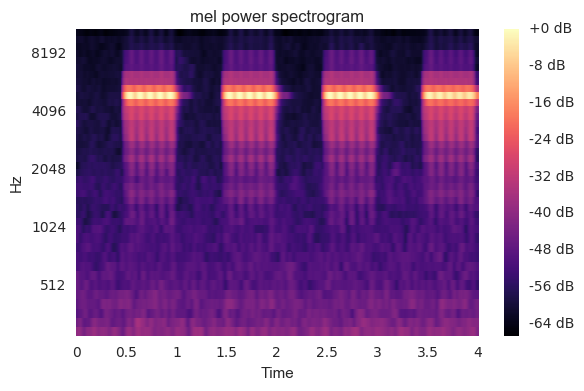

CPU times: user 4.19 s, sys: 819 ms, total: 5.01 s
Wall time: 11min 35s


In [140]:
%%time
for key in sorted(positive_classes.keys()):
    filename = os.path.join(mel_directory,key+file_sufix)
    mel_data = load_mel_data_rdd(filename)
    mel_index = calc_mel_observation_index(positive_classes[key] - (sample_rate * 0.5))
    print('Loaded. Processing mel at index: %i'%mel_index)
    mel_observation = get_mel_for_observation_index(mel_data,mel_index)
    plot_mel(mel_observation, int(sample_rate * stride))